<a href="https://colab.research.google.com/github/amr-elbana/AI-driven-post-harvest-sorting-system/blob/Ahmed-resnet50/classification-Models/Augmented_Dataset_Models/oranges_classification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense , Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
from google.colab import drive
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

!pip install keras-cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 31.7 MB/s eta 0:00:00
Using TensorFlow backend


In [ ]:
import pandas as pd
drive.mount('/content/drive', force_remount=True)
train_directory = '/content/drive/MyDrive/new_dataset/Dataset/All_oranges_Drive_Augmented'
test_directory = '/content/drive/MyDrive/new_dataset/Dataset/Test_Data'
img_height, img_width = 224, 224
batch_size = 32
epochs = 50


Mounted at /content/drive


In [ ]:
categories = os.listdir(train_directory)
nums = {}
for lebal in categories:
    nums[lebal] = len(os.listdir(os.path.join(train_directory, lebal)))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Rotten,3725
Healthy,3726


In [ ]:
categories = os.listdir(test_directory)
nums = {}
for lebal in categories:
    nums[lebal] = len(os.listdir(os.path.join(test_directory, lebal)))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Rotten,937
Healthy,931


In [ ]:


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),  # Random rotation by 20 degrees
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),  # Width and height shift by 20%
    keras_cv.layers.RandomShear(0.2, fill_mode='nearest'),  # Shearing transformation using keras_cv
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),  # Zoom in/out by 20%
    tf.keras.layers.RandomFlip("horizontal")  # Horizontal flip
])


# Load the training dataset with augmentation
train_ds = image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)

train_samples = int(7451 * 0.8)  # Assuming batch size remains constant

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)) # Apply augmentation after calculating samples



# Load the validation dataset without augmentation
val_ds = image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)
val_samples = int(7451 - train_samples)
print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")
print(f"Training batches per epoch: {len(train_ds)}")
print(f"Validation batches per epoch: {len(val_ds)}")

Found 7451 files belonging to 2 classes.
Using 5961 files for training.
Found 7451 files belonging to 2 classes.
Using 1490 files for validation.
Training samples: 5960
Validation samples: 1491
Training batches per epoch: 187
Validation batches per epoch: 47


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/50
187/187 [==============================] - 177s 911ms/step - loss: 3.1338 - accuracy: 0.8400 - val_loss: 1.4401 - val_accuracy: 0.9302
Epoch 2/50
187/187 [==============================] - 166s 880ms/step - loss: 1.4053 - accuracy: 0.8695 - val_loss: 1.1966 - val_accuracy: 0.9295
Epoch 3/50
187/187 [==============================] - 165s 879ms/step - loss: 1.1240 - accuracy: 0.8814 - val_loss: 0.9268 - val_accuracy: 0.9510
Epoch 4/50
187/187 [==============================] - 165s 876ms/step - loss: 1.0446 - accuracy: 0.8802 - val_loss: 1.0601 - val_accuracy: 0.8859
Epoch 5/50
187/187 [==============================] - 165s 878ms/step - loss: 1.0645 - accuracy: 0.8770 - val_loss: 0.8999 - val_accuracy: 0.9497
Epoch 6/50
187/187 [==============================] - 165s 878ms/step - loss: 0.9725 - accuracy: 0.8759 - val_loss: 0.9179 - val_accuracy: 0.9221
Epoch 7/50
187/187 [==============================] - 168s 

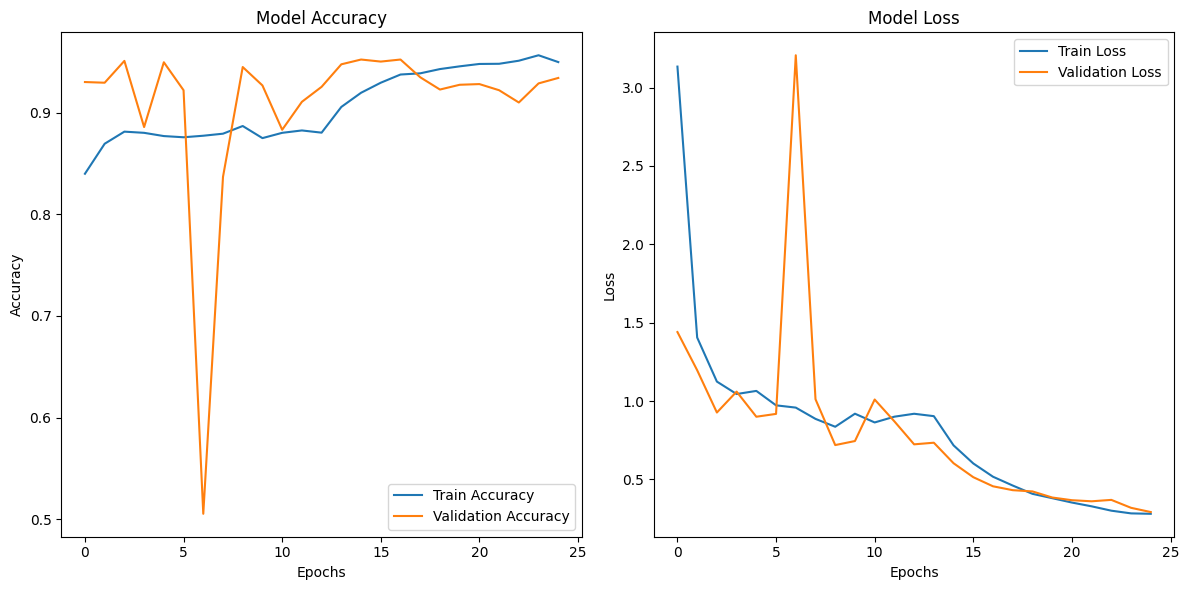

In [ ]:

# Function to create the model
def create_model():
    # Load ResNet50 base model with pretrained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Freeze base model

    # Build the model
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(384, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
        layers.BatchNormalization(),  # Batch normalization
        layers.Dropout(0.4),
        layers.Dense(2, activation='softmax')  # 2 output classes
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Initial learning rate
        loss='sparse_categorical_crossentropy',  # Suitable for binary labels
        metrics=['accuracy']
    )

    return model


# Train the model
def train_model(model, train_ds, val_ds):
    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    # Initial training with frozen base model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping]
    )

    return history


# Fine-tune the model
def fine_tune_model(model, train_ds, val_ds, base_model):
    # Unfreeze the last 10 layers of the base model
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Recompile the model with a smaller learning rate
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    # Fine-tuning
    fine_tune_history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping]
    )

    return fine_tune_history


# Plot accuracy and loss
def plot_training(history, fine_tune_history):
    # Combine histories
    full_history = {
        'accuracy': history.history['accuracy'] + fine_tune_history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'],
        'loss': history.history['loss'] + fine_tune_history.history['loss'],
        'val_loss': history.history['val_loss'] + fine_tune_history.history['val_loss']
    }

    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(full_history['accuracy'], label='Train Accuracy')
    plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(full_history['loss'], label='Train Loss')
    plt.plot(full_history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Main script
if __name__ == "__main__":

    # Create the model
    model = create_model()
    base_model = model.layers[0]  # Extract the base model for fine-tuning

    # Train the model
    history = train_model(model, train_ds, val_ds)

    # Fine-tune the model
    fine_tune_history = fine_tune_model(model, train_ds, val_ds, base_model)

    # Plot the training results
    plot_training(history, fine_tune_history)

    # Save the model
    model.save("fresh_vs_rotten_oranges_final_result.keras")


Found 1868 files belonging to 2 classes.
Confusion Matrix:
[[852  79]
 [ 19 918]]


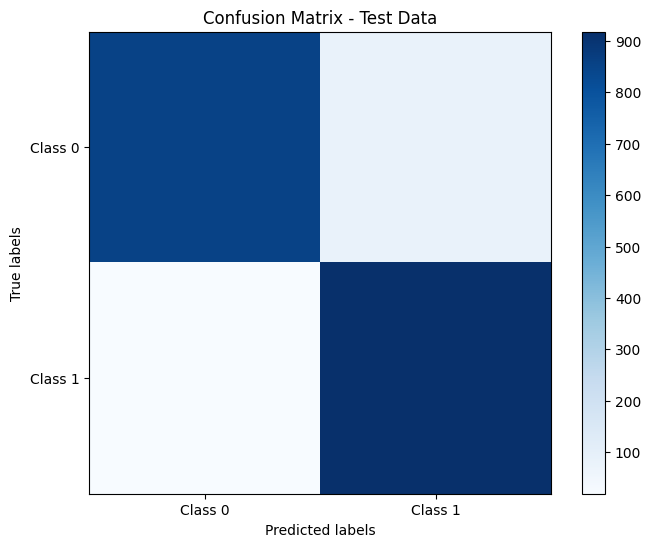

Accuracy: 0.9475
Precision: 0.9208
Recall: 0.9797
F1-Score: 0.9493


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Step 1: Load your test dataset
# Assuming you've already split your data into 'train_ds', 'val_ds', and 'test_ds'
# You can load your test data similarly to how you loaded the validation data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,  # Replace with your test directory
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'  # or 'int' depending on your number of classes
)

# Step 2: Make Predictions on the Test Set
y_true = []
y_pred = []

# Loop through the test dataset and collect true labels and predictions
for images, labels in test_ds:
    # Store the true labels
    y_true.extend(labels.numpy())

    # Predict the classes (output of the model)
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))  # Get the class with the highest probability

# Step 3: Compute the Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Print the Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.colorbar()
plt.xticks(np.arange(2), ['Class 0', 'Class 1'])  # Adjust for the number of classes
plt.yticks(np.arange(2), ['Class 0', 'Class 1'])  # Adjust for the number of classes
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Step 5: Calculate and Print Performance Metrics (Optional)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


In [ ]:
final_train_acc = fine_tune_history.history['accuracy'][-1]
final_val_acc = fine_tune_history.history['val_accuracy'][-1]
final_train_loss = fine_tune_history.history['loss'][-1]
final_val_loss = fine_tune_history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9498
Final Validation Accuracy: 0.9342
Final Training Loss: 0.2805
Final Validation Loss: 0.2916


In [ ]:
print(f"Training stopped at epoch: {len(fine_tune_history.history['loss'])}")


Training stopped at epoch: 12


In [ ]:
import json
import os

# Define the path to save the training history
history_path = os.path.join(os.getcwd(), "/content/drive/MyDrive/new_dataset/training_history.json")

# Save history to a JSON file in the current working directory
with open(history_path, "w") as f:
    json.dump(fine_tune_history.history, f)  # Use the 'history' variable instead of 'History'

# Load the history later (example)
with open(history_path, "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

{'loss': [0.9035210609436035, 0.7171435356140137, 0.6017740964889526, 0.5170378088951111, 0.46080467104911804, 0.40786781907081604, 0.3802461624145508, 0.35230687260627747, 0.32819709181785583, 0.30039969086647034, 0.2831571400165558, 0.2805422842502594], 'accuracy': [0.9057205319404602, 0.9196443557739258, 0.9295420050621033, 0.9375943541526794, 0.9387686848640442, 0.9429625868797302, 0.9456467032432556, 0.9479953050613403, 0.9481630325317383, 0.9511826634407043, 0.9565508961677551, 0.9498406052589417], 'val_loss': [0.7340819239616394, 0.603100597858429, 0.5141473412513733, 0.4559870958328247, 0.431224524974823, 0.4233088791370392, 0.3844893276691437, 0.3672512471675873, 0.3603132665157318, 0.3692806363105774, 0.31863945722579956, 0.2916134297847748], 'val_accuracy': [0.9476510286331177, 0.9523490071296692, 0.9503355622291565, 0.9523490071296692, 0.9348993301391602, 0.9228187799453735, 0.927516758441925, 0.928187906742096, 0.9221476316452026, 0.9100671410560608, 0.9288590550422668, 0.

In [ ]:
# Define where to save everything
results_save_path = "/content/drive/MyDrive/new_dataset/Models/orange_Resnet50_results.txt"
conf_matrix_save_path = "/content/drive/MyDrive/new_dataset/Models/orange_Resnet50_confusion_matrix.png"
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/new_dataset/Models/orange_Resnet50_results.txt


In [ ]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Rotten"], yticklabels=["Healthy", "Rotten"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/new_dataset/Models/orange_Resnet50_confusion_matrix.png
